In [1]:
import os
import pandas as pd

domain = "aurorasolar.com"
help_domain = 'help.aurorasolar.com'

In [43]:
# import requests
# import re
# from bs4 import BeautifulSoup
# from collections import deque
# from html.parser import HTMLParser
# from urllib.parse import urlparse

# # Regex pattern to match a URL
# HTTP_URL_PATTERN = r'^http[s]*://.+'

# # Define root domain to crawl
# domain = "aurorasolar.com"
# full_url = "https://aurorasolar.com/blog/"

# # Create a class to parse the HTML and get the hyperlinks
# class HyperlinkParser(HTMLParser):
#     def __init__(self):
#         super().__init__()
#         # Create a list to store the hyperlinks
#         self.hyperlinks = []

#     # Override the HTMLParser's handle_starttag method to get the hyperlinks
#     def handle_starttag(self, tag, attrs):
#         attrs = dict(attrs)

#         # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
#         if tag == "a" and "href" in attrs:
#             self.hyperlinks.append(attrs["href"])

# # Function to get the hyperlinks from a URL
# def get_hyperlinks(url):
    
#     # Try to open the URL and read the HTML
#     try:
#         # Open the URL and read the HTML
#         response = requests.get(url)

#         if not response.headers['content-type'].startswith('text/html'):
#             return []
        
#         html = response.text
#     except Exception as e:
#         print(f'{e}')
#         return []

#     # Create the HTML Parser and then Parse the HTML to get hyperlinks
#     parser = HyperlinkParser()
#     parser.feed(html)

#     return parser.hyperlinks

# # Function to get the hyperlinks from a URL that are within the same domain
# def get_domain_hyperlinks(local_domain, url):
#     clean_links = []
#     for link in set(get_hyperlinks(url)):
#         clean_link = None

#         # If the link is a URL, check if it is within the same domain
#         if re.search(HTTP_URL_PATTERN, link):
#             # Parse the URL and check if the domain is the same
#             url_obj = urlparse(link)
#             if url_obj.netloc == local_domain:
#                 clean_link = link

#         # If the link is not a URL, check if it is a relative link
#         else:
#             if link.startswith("/"):
#                 link = link[1:]
#             elif link.startswith("#") or link.startswith("mailto:"):
#                 continue
#             clean_link = "https://" + local_domain + "/" + link

#         if clean_link is not None:
#             if clean_link.endswith("/"):
#                 clean_link = clean_link[:-1]
#             clean_links.append(clean_link)

#     # Return the list of hyperlinks that are within the same domain
#     return list(set(clean_links))


# def crawl(url):
#     # Parse the URL and get the domain
#     local_domain = urlparse(url).netloc

#     # Create a queue to store the URLs to crawl
#     queue = deque([url])

#     # Create a set to store the URLs that have already been seen (no duplicates)
#     seen = set([url])

#     # Create a directory to store the text files
#     if not os.path.exists("text/"):
#             os.mkdir("text/")

#     if not os.path.exists("text/"+local_domain+"/"):
#             os.mkdir("text/" + local_domain + "/")

#     # Create a directory to store the csv files
#     if not os.path.exists("processed"):
#             os.mkdir("processed")

#     # While the queue is not empty, continue crawling
#     while queue:

#         # Get the next URL from the queue
#         url = queue.pop()
#         print(url) # for debugging and to see the progress

#         # Save text from the url to a <url>.txt file
#         file = 'text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt"
#         with open(file, "w") as f:

#             # Get the text from the URL using BeautifulSoup
#             soup = BeautifulSoup(requests.get(url).text, "html.parser")

#             # Get the text but remove the tags
#             text = soup.get_text()

#             # If the crawler gets to a page that requires JavaScript, it will stop the crawl
#             if ("You need to enable JavaScript to run this app." in text):
#                 print("Unable to parse page " + url + " due to JavaScript being required")
            
#             # Otherwise, write the text to the file in the text directory
#             f.write(text)

#         # Get the hyperlinks from the URL and add them to the queue
#         for link in get_domain_hyperlinks(local_domain, url):
#             if link not in seen:
#                 queue.append(link)
#                 seen.add(link)

# crawl(full_url)

https://aurorasolar.com/blog/
Writing file: ./text/aurorasolar.com/aurorasolar.com_blog_.txt
https://aurorasolar.com/pricing
Writing file: ./text/aurorasolar.com/aurorasolar.com_pricing.txt
https://aurorasolar.com/public-demo/?cta_click=pricing-basic
Writing file: ./text/aurorasolar.com/aurorasolar.com_public-demo_?cta_click=pricing-basic.txt
https://aurorasolar.com/public-demo/?cta_click=pricing-custom
Writing file: ./text/aurorasolar.com/aurorasolar.com_public-demo_?cta_click=pricing-custom.txt
https://aurorasolar.com/public-demo/?cta_click=pricing-basic=pricing-custom
Writing file: ./text/aurorasolar.com/aurorasolar.com_public-demo_?cta_click=pricing-basic=pricing-custom.txt
https://aurorasolar.com/public-demo/?cta_click=pricing-premium
Writing file: ./text/aurorasolar.com/aurorasolar.com_public-demo_?cta_click=pricing-premium.txt
https://aurorasolar.com/privacy-policy
Writing file: ./text/aurorasolar.com/aurorasolar.com_privacy-policy.txt
https://aurorasolar.com/blog/?filters[topic

TooManyRedirects: Exceeded 30 redirects.

In [30]:
# import requests
# from bs4 import BeautifulSoup

# help_domain = 'help.aurorasolar.com'
# next_page = "https://help.aurorasolar.com/api/v2/help_center/en-us/articles.json?per_page=100"
# headers = {}

# # Create a directory to store the text files
# if not os.path.exists("text/"):
#     os.mkdir("text/")

# if not os.path.exists("text/" + help_domain + "/"):
#     os.mkdir("text/" + help_domain + "/")

# while (next_page is not None):
#     print(next_page)
#     response = requests.get(next_page, headers=headers)
#     json = response.json()

#     next_page = json["next_page"]

#     for article in json["articles"]:
#         id = article["id"]
#         title = article["title"]
#         print(f"Article {id}: {title}")
#         print(article['html_url'])
#         body = article["body"]
#         soup = BeautifulSoup(f'{title}\n\n{body}', "html.parser")
#         text = soup.get_text()

#         url = article['html_url']
#         fname = f"text/{help_domain}/{url.replace('/', ':')}.txt"
#         with open(fname, "w") as f:
#             f.write(text)


https://help.aurorasolar.com/api/v2/help_center/en-us/articles.json?per_page=100
https://help.aurorasolar.com/hc/en-us/articles/15734774769555-How-to-Select-Your-Financing-Product-in-the-New-Financing-Dropdown-in-Sales-Mode
Article 15734774769555: How to Select Your Financing Product in the New Financing Dropdown in Sales Mode
https://help.aurorasolar.com/hc/en-us/articles/15548879828499-Applying-for-a-Loan-Through-Our-Financing-Integrations
Article 15548879828499: Applying for a Loan Through Our Financing Integrations
https://help.aurorasolar.com/hc/en-us/articles/15453305274643-Assessing-Shading-Threats-in-Sales-Mode
Article 15453305274643: Assessing Shading Threats in Sales Mode
https://help.aurorasolar.com/hc/en-us/articles/15013490763283-Requesting-a-3D-Site-Model-Using-Aurora-s-Expert-Design-Services-in-Sales-Mode
Article 15013490763283: Requesting a 3D Site Model Using Aurora's Expert Design Services in Sales Mode
https://help.aurorasolar.com/hc/en-us/articles/14993382052371-Add

https://help.aurorasolar.com/hc/en-us/articles/5942298057875-Lead-Capture-AI-Overview
Article 5942298057875: Lead Capture AI Overview
https://help.aurorasolar.com/hc/en-us/articles/5862510149395-Live-Class-Aurora-Power-Hour
Article 5862510149395: Live Class - Aurora Power Hour
https://help.aurorasolar.com/hc/en-us/articles/5802206024723-04-06-2022-Release-Notes
Article 5802206024723: 04/06/2022 Release Notes
https://help.aurorasolar.com/hc/en-us/articles/5800184650515-03-28-2022-Release-Notes
Article 5800184650515: 03/28/2022 Release Notes
https://help.aurorasolar.com/hc/en-us/articles/5520377110291-Plan-Sets
Article 5520377110291: Plan Sets
https://help.aurorasolar.com/hc/en-us/articles/5022256920723-Quick-Start-Videos-New-Aurora-
Article 5022256920723: Quick Start Videos (New Aurora)
https://help.aurorasolar.com/hc/en-us/articles/5013786524179-03-23-2022-Release-Notes
Article 5013786524179: 03/23/2022 - Release Notes
https://help.aurorasolar.com/hc/en-us/articles/4688974468499-03-14-

https://help.aurorasolar.com/hc/en-us/articles/12110730000915-Map-Imagery-Selection
Article 12110730000915: Map Imagery Selection
https://help.aurorasolar.com/hc/en-us/articles/11243297648531-AHJ-Identification-and-Database
Article 11243297648531: AHJ Identification and Database
https://help.aurorasolar.com/hc/en-us/articles/5949413192595-Selecting-an-Overview-Page-Background-Image
Article 5949413192595: Selecting an Overview Page Background Image
https://help.aurorasolar.com/hc/en-us/articles/4418624057363-02-09-2022-Release-Notes
Article 4418624057363: 02/09/2022 - Release Notes
https://help.aurorasolar.com/hc/en-us/articles/1500000287281-Placeholders
Article 1500000287281: Placeholders
https://help.aurorasolar.com/hc/en-us/articles/360052931834-What-s-New-In-Aurora-System-Design
Article 360052931834: What's New In Aurora System Design
https://help.aurorasolar.com/hc/en-us/articles/360037204154-10-03-2019-Release-Notes
Article 360037204154: 10/03/2019 Release Notes
https://help.auror

https://help.aurorasolar.com/hc/en-us/articles/115001339907-Global-MPPT-and-Bypass-Diodes
Article 115001339907: Global MPPT and Bypass Diodes
https://help.aurorasolar.com/hc/en-us/articles/234582168-Part-2-Create-a-Site-Design
Article 234582168: Part 2. Create a Site Design
https://help.aurorasolar.com/hc/en-us/articles/220450087-Glossary
Article 220450087: Glossary
https://help.aurorasolar.com/hc/en-us/articles/12290612935699-Creating-a-Site-Model-Using-Aurora-AI-in-Sales-Mode
Article 12290612935699: Creating a Site Model Using Aurora AI in Sales Mode
https://help.aurorasolar.com/hc/en-us/articles/4402158957715-SmartRoof-Best-Practices-and-Tips
Article 4402158957715: SmartRoof Best Practices and Tips
https://help.aurorasolar.com/hc/en-us/articles/360049837474-How-to-Model-for-New-Construction
Article 360049837474: How to Model for New Construction
https://help.aurorasolar.com/hc/en-us/articles/360025881353-6-28-19-Release-Notes
Article 360025881353: 6/28/19 Release Notes
https://help.

https://help.aurorasolar.com/hc/en-us/articles/360026236194-07-11-2019-Shading-Engine-Update
Article 360026236194: 07/11/2019- Shading Engine Update
https://help.aurorasolar.com/hc/en-us/articles/360010248393-10-05-2018-Release-Notes-
Article 360010248393: 10/05/2018 Release Notes 
https://help.aurorasolar.com/hc/en-us/articles/115011335727-Adding-walkways
Article 115011335727: Adding walkways
https://help.aurorasolar.com/hc/en-us/articles/229645247-How-to-Copy-and-Paste-Proposal-Objects
Article 229645247: How to Copy and Paste Proposal Objects
https://help.aurorasolar.com/hc/en-us/articles/360009655713-9-21-18-Release-Notes
Article 360009655713: 9/21/18 Release Notes
https://help.aurorasolar.com/hc/en-us/articles/360007996073-Submitting-a-Request-to-our-3D-Modeling-Service
Article 360007996073: Submitting a Request to our 3D Modeling Service
https://help.aurorasolar.com/hc/en-us/articles/115011433988-How-to-Rename-a-Proposal-Template
Article 115011433988: How to Rename a Proposal Temp

In [1]:
# def remove_newlines(serie):
#     serie = serie.str.replace('\n', ' ')
#     serie = serie.str.replace('\\n', ' ')
#     serie = serie.str.replace('  ', ' ')
#     serie = serie.str.replace('  ', ' ')
#     return serie

In [46]:
# import pandas as pd

# # Create a list to store the text files
# texts=[]

# # Get all the text files in the text directory
# for dir in [domain, help_domain]:
#     for file in os.listdir(f"text/{dir}/"):
#         # Open the file and read the text
#         with open(f"text/{dir}/{file}", "r") as f:
#             text = f.read()

#             # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
#             if dir == domain:
#                 fname = file[:-4].replace(':', '/').replace('/', ':', 1).replace('_', '/')
#             else:
#                 assert dir == help_domain
#                 fname = file[8:-4].replace(':', '/')
#             texts.append((fname, text))
# #             print(fname)  # TODO: Comment out
# #             print(text)  # TODO: Comment out
# #             break  # TODO: Comment out

# # Create a dataframe from the list of texts
# df = pd.DataFrame(texts, columns = ['fname', 'text'])

# # Set the text column to be the raw text with the newlines removed
# df['text'] = df.fname + ": " + remove_newlines(df.text)
# df.to_csv('processed/scraped.csv')  # TODO: Uncomment out
# df

/var/folders/76/slsg2m897b9bx279592x5gg80000gn/T/ipykernel_56031/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,aurorasolar.com/blog/the-beginners-guide-to-so...,aurorasolar.com/blog/the-beginners-guide-to-so...
1,aurorasolar.com/resources/tackling-every-sale-...,aurorasolar.com/resources/tackling-every-sale-...
2,aurorasolar.com/resources/how-to-sell-with-aur...,aurorasolar.com/resources/how-to-sell-with-aur...
3,aurorasolar.com/what-is-a-green-bank-how-these...,aurorasolar.com/what-is-a-green-bank-how-these...
4,aurorasolar.com/resources/create-instantly-per...,aurorasolar.com/resources/create-instantly-per...
...,...,...
923,help.aurorasolar.com/hc/en-us/articles/2204501...,help.aurorasolar.com/hc/en-us/articles/2204501...
924,help.aurorasolar.com/hc/en-us/articles/3600337...,help.aurorasolar.com/hc/en-us/articles/3600337...
925,help.aurorasolar.com/hc/en-us/articles/1473219...,help.aurorasolar.com/hc/en-us/articles/1473219...
926,help.aurorasolar.com/hc/en-us/articles/1500009...,help.aurorasolar.com/hc/en-us/articles/1500009...


<AxesSubplot: >

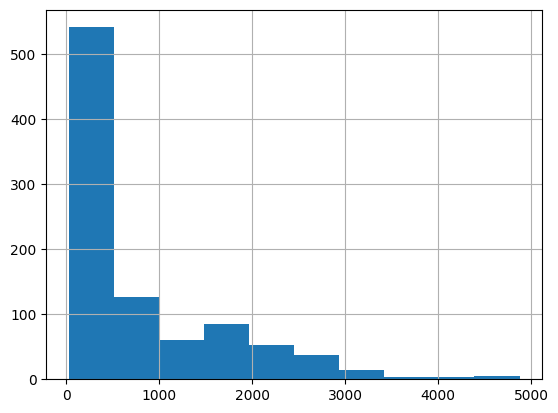

In [2]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [3]:
df

,title,text,n_tokens
0,aurorasolar.com/blog/the-beginners-guide-to-so...,aurorasolar.com/blog/the-beginners-guide-to-so...,1826
1,aurorasolar.com/resources/tackling-every-sale-...,aurorasolar.com/resources/tackling-every-sale-...,399
2,aurorasolar.com/resources/how-to-sell-with-aur...,aurorasolar.com/resources/how-to-sell-with-aur...,467
3,aurorasolar.com/what-is-a-green-bank-how-these...,aurorasolar.com/what-is-a-green-bank-how-these...,1842
4,aurorasolar.com/resources/create-instantly-per...,aurorasolar.com/resources/create-instantly-per...,481
...,...,...,...
923,help.aurorasolar.com/hc/en-us/articles/2204501...,help.aurorasolar.com/hc/en-us/articles/2204501...,995
924,help.aurorasolar.com/hc/en-us/articles/3600337...,help.aurorasolar.com/hc/en-us/articles/3600337...,342
925,help.aurorasolar.com/hc/en-us/articles/1473219...,help.aurorasolar.com/hc/en-us/articles/1473219...,252
926,help.aurorasolar.com/hc/en-us/articles/1500009...,help.aurorasolar.com/hc/en-us/articles/1500009...,76


In [4]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

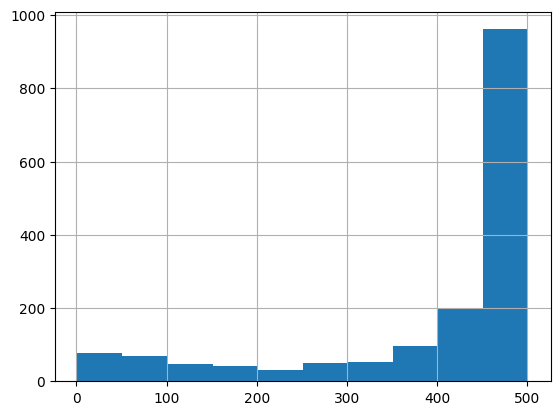

In [5]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [6]:
df

,text,n_tokens
0,aurorasolar.com/blog/the-beginners-guide-to-so...,495
1,The chart below illustrates the correlation be...,486
2,The US Department of Energy’s National Renewab...,455
3,aurorasolar.com/resources/tackling-every-sale-...,399
4,aurorasolar.com/resources/how-to-sell-with-aur...,467
...,...,...
1618,Module Nameplate Rating (default 0%): Account ...,478
1619,help.aurorasolar.com/hc/en-us/articles/3600337...,342
1620,help.aurorasolar.com/hc/en-us/articles/1473219...,252
1621,help.aurorasolar.com/hc/en-us/articles/1500009...,76


In [7]:
import openai
openai.api_key_path = '.api_key'

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,aurorasolar.com/blog/the-beginners-guide-to-so...,495,"[0.027047593146562576, -0.029446152970194817, ..."
1,The chart below illustrates the correlation be...,486,"[0.022480249404907227, -0.015244338661432266, ..."
2,The US Department of Energy’s National Renewab...,455,"[0.015759315341711044, -0.005848485976457596, ..."
3,aurorasolar.com/resources/tackling-every-sale-...,399,"[0.006310301832854748, -0.02134528197348118, 0..."
4,aurorasolar.com/resources/how-to-sell-with-aur...,467,"[0.017267361283302307, -0.010548543184995651, ..."


In [8]:
import pandas as pd
import numpy as np

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,aurorasolar.com/blog/the-beginners-guide-to-so...,495,"[0.027047593146562576, -0.029446152970194817, ..."
1,The chart below illustrates the correlation be...,486,"[0.022480249404907227, -0.015244338661432266, ..."
2,The US Department of Energy’s National Renewab...,455,"[0.015759315341711044, -0.005848485976457596, ..."
3,aurorasolar.com/resources/tackling-every-sale-...,399,"[0.006310301832854748, -0.02134528197348118, 0..."
4,aurorasolar.com/resources/how-to-sell-with-aur...,467,"[0.017267361283302307, -0.010548543184995651, ..."


In [61]:
from openai.embeddings_utils import distances_from_embeddings

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="What is Aurora Solar?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [62]:
answer_question(df, question="How do I create a web proposal?")

'To generate and send a web proposal in Sales Mode, click “Share” from the Sales Mode drop down menu. You can access this menu from almost any page in Sales Mode. Click share, and Aurora generates a unique URL for each design that you create in Sales Mode. Enter the homeowner’s email address and click Send to email them a link to their dynamic Web Proposal. You can also copy the link, open the link in a new browser tab, or refresh the link.'

In [63]:
answer_question(df, question="How do I use lidar?")

'After completing your design, click on the LIDAR button on the top menu. Toggle into the 3D view by clicking the 3D box icon (or holding right click) and moving your cursor up. Click the LIDAR Settings button to toggle between Mesh or Point Cloud. Adjust the LIDAR data by using the x, y, and z coordinate fields. After calibrating LIDAR, click on the Fit Buildings to LIDAR button to fit your design to the LIDAR data. Note: you can also view or switch the source of LIDAR data in the LIDAR settings menu.'